In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import autograd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm

sns.set_style("whitegrid")

## REBAR helpers

In [2]:
def log_pb_bern(b, theta):
    """ Log probability of Bernoulli distribution. """
    return torch.log(theta) * b + torch.log(1 - theta) * (1 - b)

def g(u, theta):
    """ 
    Differentiable reparametrization of z.

    Givem u ~ U(0, 1), and theta from (0, 1).
    Return a sample from p(z). Logistic distribution.
    """
    return torch.log(theta / (1 - theta)) + torch.log(u / (1 - u))


def g_tilde(v, b, theta):
    """
    Differentiable reparametrization of z|b.

    Given v ~ U(0, 1), b ~ Bernoulli(theta).
    and theta from (0, 1).

    Return a sample from the distribution p(z|b).
    """
    zb1 = torch.log((v / (1 - v)) * (1/(1-theta)) + 1)
    zb0 = -torch.log((v / (1 - v)) * (1/theta) + 1)
    return torch.where(b == 1, zb1, zb0)


def H(z):
    """
    The hard threshold function.
    """
    return torch.where(z >= 0, 1, 0)


def sigma(z, lmbda = 1):
    """
    Sigmoid with a temperature parameter.
    """
    return torch.sigmoid(z / lmbda)


def g_lmbda(u, theta, lmbda = 1):
    """
    Differentiable reparametrization of z_lmbda.

    After sigma this makes an alternative to sigma(g(u, theta), lmbda).
    lmbda must be the same for both g_lmbda and sigma.
    """
    quadratic = (lmbda**2 + lmbda + 1)/(lmbda + 1)
    z_lmbda = quadratic * torch.log(theta / (1 - theta)) + torch.log(u / (1 - u))
    return z_lmbda

## Data

<Axes: ylabel='Count'>

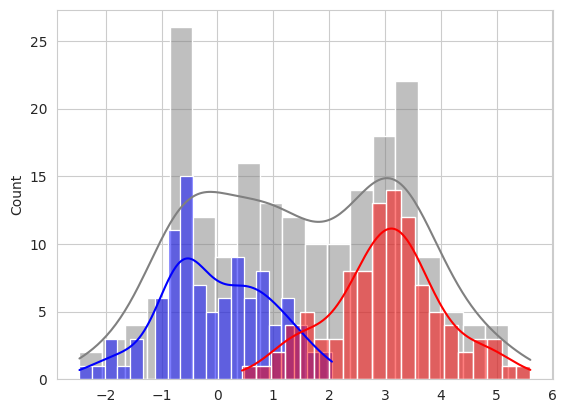

In [3]:
Xs = torch.concatenate([
    torch.randn(100),
    torch.randn(100) + 3,
]).reshape(-1, 1)
y_true = torch.concatenate([
    torch.zeros(100),
    torch.ones(100),
]).reshape(-1)

sns.histplot(Xs[:, 0], bins=20, kde=True, color='gray', alpha=0.5)
sns.histplot(Xs[:100, 0], bins=20, kde=True, color='blue', alpha=0.5)
sns.histplot(Xs[100:, 0], bins=20, kde=True, color='red', alpha=0.5)

## Logistic regression model

In [4]:
class LogRegression(nn.Module):
    """
    Logistic regression model.
    """
    def __init__(self, input_dim, output_dim):
        super(LogRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.sigmoid(self.linear(x))
        return y

## Objective to maximize

In [5]:
def f(b):
    """ Negative Log likelihood for this simple GMM model"""
    return (1/2) * (Xs - 3*b) ** 2

100%|██████████| 5000/5000 [00:09<00:00, 552.81it/s]


<Axes: >

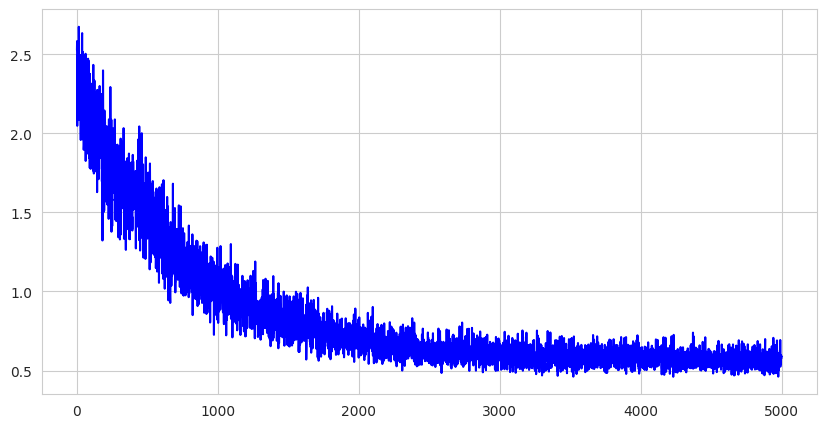

In [6]:
model = LogRegression(1, 1)
lmbda = torch.tensor([1.0], requires_grad=True)
eta = torch.tensor([0.1], requires_grad=True)

opt = torch.optim.Adam([lmbda, eta, *model.parameters()], lr=0.001, betas=(0.9, 0.99999))
n = 1

objectives = []

for i in tqdm(range(5000)):
    opt.zero_grad()

    thetas_pred = model.forward(Xs)

    # Gradient estimation
    thetas = thetas_pred.detach()
    thetas.requires_grad = True

    loss = 0
    for _ in range(n):
        u, v = torch.rand(2, thetas.shape[0], 1)

        z_lmbda = g_lmbda(u, thetas, lmbda)
        b = H(z_lmbda).detach()
        z_tilde = g_tilde(v, b, thetas)

        obj = f(b)
        objectives.append(torch.mean(obj).item())
        first_term = (obj - eta * f(sigma(z_tilde.detach(), lmbda))) * log_pb_bern(b, thetas)
        second_term = eta * f(sigma(z_lmbda, lmbda))
        thrid_term = -eta * f(sigma(z_tilde, lmbda))
        loss += first_term + second_term + thrid_term

    loss /= n

    grad_estimate = autograd.grad(torch.mean(loss), thetas, create_graph=True)[0]

    eta.grad, lmbda.grad = autograd.grad(torch.mean(grad_estimate ** 2), (eta, lmbda))


    autograd.backward(thetas_pred, grad_estimate.detach())
    opt.step()

    lmbda.data = torch.clamp(lmbda.data, 0.001)


plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(objectives)), y=objectives, color='blue')

Accuracy: 0.9200000166893005


<Axes: xlabel='None', ylabel='None'>

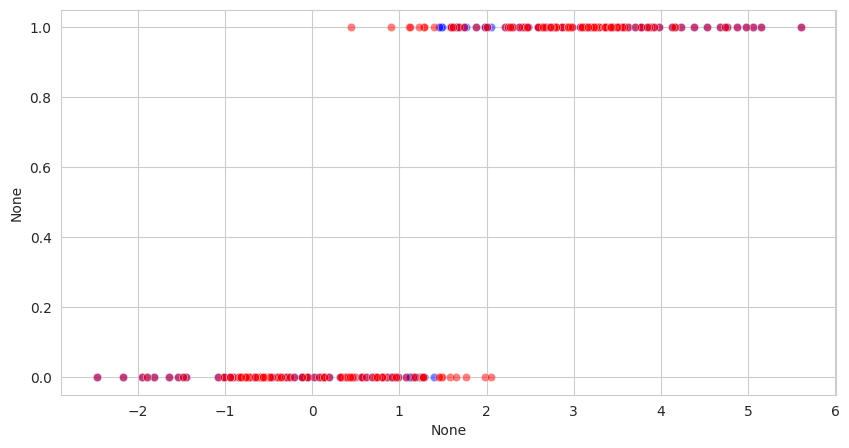

In [7]:
with torch.no_grad():
    y_pred = (model.forward(Xs) > 0.5).reshape(-1)
    print(f"Accuracy: {torch.mean((y_pred == y_true) * 1.0)}")

plt.figure(figsize=(10, 5))
sns.scatterplot(x=Xs[:, 0], y=y_pred, color='blue', alpha=0.5)
sns.scatterplot(x=Xs[:, 0], y=y_true, color='red', alpha=0.5)
